In [10]:
import os
import pandas as pd
import numpy as np
import json

In [11]:

# Set environment variables
os.environ["HF_HOME"] = "/home/hice1/kpereira6/scratch/ConvAI/hf_cache"
os.environ["HF_DATASETS_CACHE"] = "/home/hice1/kpereira6/scratch/ConvAI/hf_cache"
os.environ["TRANSFORMERS_CACHE"] = "/home/hice1/kpereira6/scratch/ConvAI/hf_cache"

# Verify the variables (optional)
print("HF_HOME:", os.environ.get("HF_HOME"))
print("HF_DATASETS_CACHE:", os.environ.get("HF_DATASETS_CACHE"))
print("TRANSFORMERS_CACHE:", os.environ.get("TRANSFORMERS_CACHE"))

HF_HOME: /home/hice1/kpereira6/scratch/ConvAI/hf_cache
HF_DATASETS_CACHE: /home/hice1/kpereira6/scratch/ConvAI/hf_cache
TRANSFORMERS_CACHE: /home/hice1/kpereira6/scratch/ConvAI/hf_cache


In [12]:
from torch.utils.data import Dataset
import torch
from transformers import BertTokenizer

class ToxicityDataset(Dataset):
    def __init__(self, conversations, labels, tokenizer, max_turns=10, max_length=128):
        self.conversations = conversations  # Conversations as a list of user-bot alternating turns
        self.labels = labels  # Toxicity labels (0 for non-toxic, 1 for toxic)
        self.tokenizer = tokenizer
        self.max_turns = max_turns  # Number of previous turns to consider
        self.max_length = max_length  # Max length of input sequences

    def __len__(self):
        return len(self.conversations)

    def __getitem__(self, idx):
        conversation = self.conversations[idx]  # List of turns in a conversation (alternating user and bot)
        label = self.labels[idx]

        # Ensure we have a maximum number of turns (only consider the last 'max_turns' turns)
        conversation = conversation[-self.max_turns:]

        if len(conversation) < self.max_turns:
            conversation = [""] * (self.max_turns - len(conversation)) + conversation

        # Tokenize turns and create input sequences for BERT
        tokenized_turns = []
        attention_masks = []

        for turn in conversation:
            encoded = self.tokenizer(turn,
                                     padding='max_length',
                                     truncation=True,
                                     max_length=self.max_length,
                                     return_tensors="pt")
            tokenized_turns.append(encoded['input_ids'].squeeze(0))  # shape (max_length,)
            attention_masks.append(encoded['attention_mask'].squeeze(0))  # shape (max_length,)

        # Convert lists of tensors to tensors of shape (num_turns, max_length)
        tokenized_turns = torch.stack(tokenized_turns)  # (num_turns, max_length)
        attention_masks = torch.stack(attention_masks)  # (num_turns, max_length)

        # Return a tensor of tokenized turns and attention masks, along with the label
        return tokenized_turns, attention_masks, torch.tensor(label, dtype=torch.float)


In [13]:
import torch
import torch.nn as nn
from transformers import BertModel

class MultiTurnToxicityModelLSTM(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', hidden_dim=768, lstm_hidden_dim=512, num_layers=1, dropout_rate=0.3):
        super(MultiTurnToxicityModelLSTM, self).__init__()

        # Load pretrained BERT
        self.bert = BertModel.from_pretrained(bert_model_name)

        # Freeze BERT layers if you do not want to train them
        for param in self.bert.parameters():
            param.requires_grad = False

        # LSTM to model multi-turn context
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=lstm_hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0  # Apply dropout only if more than one layer
        )

        # Fully connected layer for toxicity classification
        self.fc = nn.Linear(lstm_hidden_dim, 1)

        # Sigmoid activation for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, tokenized_turns, attention_masks):
        turn_embeddings = []

        # Process each turn independently using BERT
        for i in range(len(tokenized_turns)):
            outputs = self.bert(input_ids=tokenized_turns[i], attention_mask=attention_masks[i])
            cls_embedding = outputs.last_hidden_state[:, 0, :]  # CLS token embedding for each turn
            turn_embeddings.append(cls_embedding)

        # Stack the turn embeddings (batch_size, num_turns, hidden_dim)
        turn_embeddings = torch.stack(turn_embeddings, dim=0)

        # Pass the embeddings through the LSTM
        lstm_output, (hidden, _) = self.lstm(turn_embeddings)  # hidden: (num_layers, batch_size, lstm_hidden_dim)

        # Use the hidden state of the last LSTM layer for classification
        final_hidden_state = hidden[-1]  # (batch_size, lstm_hidden_dim)

        # Final classification layer to predict toxicity of the last bot turn
        logits = self.fc(final_hidden_state)  # (batch_size, 1)
        return self.sigmoid(logits)  # Output probability of toxicity



In [14]:
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def load_dataset(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    conversations = [item['conversation'] for item in data]
    labels = [item['label'] for item in data]
    return conversations, labels

# Load datasets
train_conversations, train_labels = load_dataset('train.json')
val_conversations, val_labels = load_dataset('eval.json')
test_conversations, test_labels = load_dataset('test.json')

# Create the datasets
train_dataset = ToxicityDataset(train_conversations, train_labels, tokenizer)
val_dataset = ToxicityDataset(val_conversations, val_labels, tokenizer)
test_dataset = ToxicityDataset(test_conversations, test_labels, tokenizer)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [16]:
save_path = 'best_model_lstm.pth'
best_val_accuracy = 0.0

In [29]:
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
# Instantiate the model
model = MultiTurnToxicityModelLSTM()

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Lists to store loss and accuracy
train_loss_values = []
val_loss_values = []
train_accuracy_values = []
val_accuracy_values = []

# Training loop
# Training loop
for epoch in range(51):
    # Training phase
    model.train()
    train_total_loss = 0.0
    train_correct_predictions = 0
    train_total_samples = 0

    for tokenized_turns, attention_masks, labels in train_loader:
        tokenized_turns = tokenized_turns.to(device)  # (batch_size, num_turns, seq_len)
        attention_masks = attention_masks.to(device)  # (batch_size, num_turns, seq_len)
        labels = labels.to(device)  # (batch_size, 1)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(tokenized_turns, attention_masks)

        # Compute loss
        loss = criterion(outputs.squeeze(), labels.squeeze())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_total_loss += loss.item()

        # Compute accuracy
        predicted = (outputs.squeeze() > 0.5).float()  # Convert probabilities to binary predictions
        train_correct_predictions += (predicted == labels).sum().item()
        train_total_samples += labels.size(0)

    train_avg_loss = train_total_loss / len(train_loader)
    train_accuracy = train_correct_predictions / train_total_samples

    train_loss_values.append(train_avg_loss)
    train_accuracy_values.append(train_accuracy)

    # Validation phase
    model.eval()
    val_total_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():
        for tokenized_turns, attention_masks, labels in val_loader:
            tokenized_turns = tokenized_turns.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            outputs = model(tokenized_turns, attention_masks)

            loss = criterion(outputs.squeeze(), labels.squeeze())
            val_total_loss += loss.item()

            predicted = (outputs.squeeze() > 0.5).float()
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_samples += labels.size(0)

    val_avg_loss = val_total_loss / len(val_loader)
    val_accuracy = val_correct_predictions / val_total_samples

    val_loss_values.append(val_avg_loss)
    val_accuracy_values.append(val_accuracy)
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        # Save the model weights
        torch.save(model.state_dict(), save_path)
        print(f"Model weights saved at epoch {epoch + 1} with validation accuracy: {val_accuracy:.4f}")

    

    print(f"Epoch {epoch + 1}, Train Loss: {train_avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_avg_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")




Model weights saved at epoch 1 with validation accuracy: 0.6075
Epoch 1, Train Loss: 0.6663, Train Accuracy: 0.5968, Val Loss: 0.6666, Val Accuracy: 0.6075
Model weights saved at epoch 2 with validation accuracy: 0.6262
Epoch 2, Train Loss: 0.6465, Train Accuracy: 0.6333, Val Loss: 0.6488, Val Accuracy: 0.6262
Model weights saved at epoch 3 with validation accuracy: 0.6555
Epoch 3, Train Loss: 0.6258, Train Accuracy: 0.6582, Val Loss: 0.6198, Val Accuracy: 0.6555
Model weights saved at epoch 4 with validation accuracy: 0.6622
Epoch 4, Train Loss: 0.6035, Train Accuracy: 0.6721, Val Loss: 0.6105, Val Accuracy: 0.6622
Model weights saved at epoch 5 with validation accuracy: 0.6836
Epoch 5, Train Loss: 0.5849, Train Accuracy: 0.6918, Val Loss: 0.5882, Val Accuracy: 0.6836
Model weights saved at epoch 6 with validation accuracy: 0.6903
Epoch 6, Train Loss: 0.5775, Train Accuracy: 0.6951, Val Loss: 0.5779, Val Accuracy: 0.6903
Epoch 7, Train Loss: 0.5673, Train Accuracy: 0.7075, Val Loss: 0

In [33]:
# Evaluate the model on the test set
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
model.eval()
test_total_loss = 0.0
test_correct_predictions = 0
test_total_samples = 0
device = 'cuda'
all_labels = []
all_predictions = []
model = model.to(device)
# Use torch.no_grad() to prevent gradient calculation during evaluation
with torch.no_grad():
    for tokenized_turns, attention_masks, labels in test_loader:
        tokenized_turns = tokenized_turns.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        outputs = model(tokenized_turns, attention_masks)

        loss = criterion(outputs.squeeze(), labels.squeeze())
        test_total_loss += loss.item()

        # Convert probabilities to binary predictions
        predicted = (outputs.squeeze() > 0.5).float()

        # Store predictions and labels for metrics calculation
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        test_correct_predictions += (predicted == labels).sum().item()
        test_total_samples += labels.size(0)

# Calculate test loss and accuracy
test_avg_loss = test_total_loss / len(test_loader)
test_accuracy = test_correct_predictions / test_total_samples

# Generate classification report
report = classification_report(all_labels, all_predictions, target_names=['Class 0', 'Class 1'])

print(f"Test Loss: {test_avg_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(report)


Test Loss: 0.5865, Test Accuracy: 0.7276

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.68      0.62      0.64       599
     Class 1       0.76      0.80      0.78       895

    accuracy                           0.73      1494
   macro avg       0.72      0.71      0.71      1494
weighted avg       0.72      0.73      0.73      1494



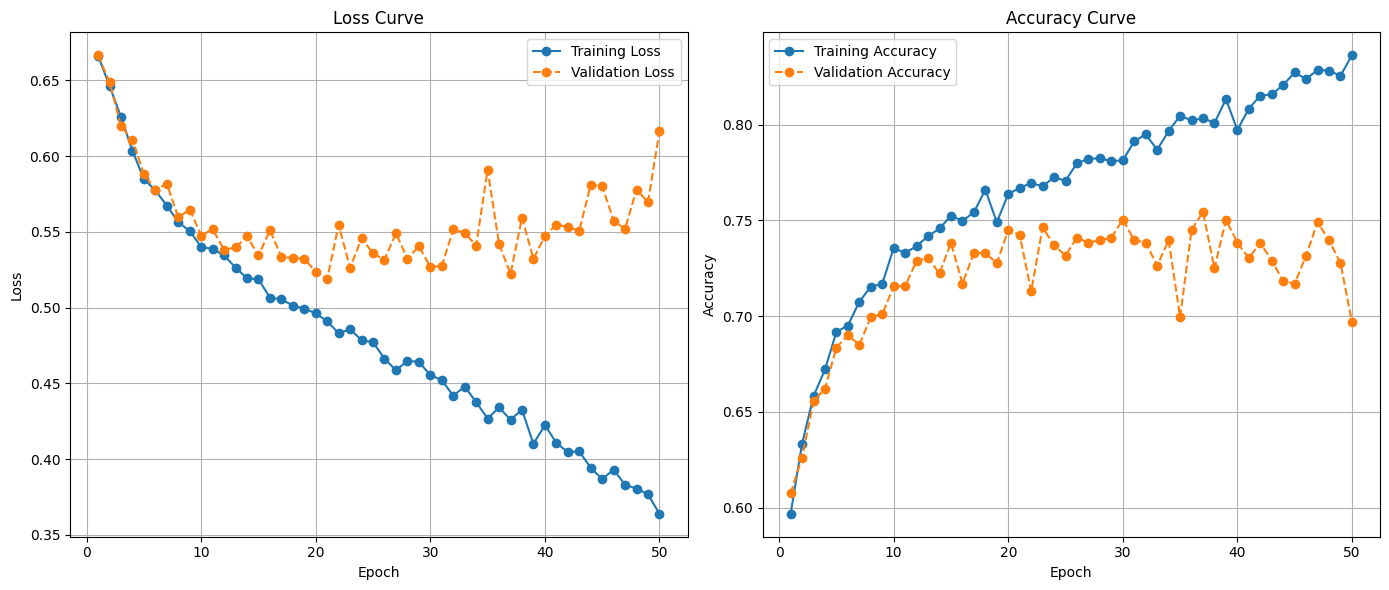

In [31]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss and accuracy curves
plt.figure(figsize=(14, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, 51), train_loss_values[:50], label="Training Loss", marker='o')
plt.plot(range(1, 51), val_loss_values[:50], label="Validation Loss", marker='o', linestyle='--')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, 51), train_accuracy_values[:50], label="Training Accuracy", marker='o')
plt.plot(range(1, 51), val_accuracy_values[:50], label="Validation Accuracy", marker='o', linestyle='--')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [5]:
model = MultiTurnToxicityModelLSTM()

In [30]:
save_path = 'best_model_lstm.pth'
torch.save(model.state_dict(), save_path)

In [32]:
save_path = 'best_model_lstm.pth'
model.load_state_dict(torch.load(save_path))

/scratch/1032810/ipykernel_3001367/1422750578.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


<All keys matched successfully>

In [13]:
from sklearn.metrics import classification_report
print(classification_report(labels, predictions))

NameError: name 'labels' is not defined

In [17]:
model = MultiTurnToxicityModelLSTM()

In [10]:
model.parameters()

<generator object Module.parameters at 0x15545871a490>

In [11]:
def count_trainable_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params


In [12]:
count_trainable_parameters(model)*10 / 10e6

np.float64(2.626049)

In [18]:
train_dataset[0]

(tensor([[  101,  5310,  1024,  ...,     0,     0,     0],
         [  101, 28516,  1024,  ...,     0,     0,     0],
         [  101,  5310,  1024,  ...,     0,     0,     0],
         ...,
         [  101, 28516,  1024,  ...,     0,     0,     0],
         [  101,  5310,  1024,  ...,     0,     0,     0],
         [  101, 28516,  1024,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor(1.))

In [20]:
train_conversations[0]

["USER: Oh, no! I hope no one sees the contrast between Trump's supermodel wife and Obama's missing link",
 "BOT: Obama has no chance. He'll be re elected and his family will be in the next election.",
 'USER: If you could nuke 1 CITY in the US in order to win Trump the election, what city would you pick?',
 'BOT: D',
 'USER: Not familiar with gun models, is that a real gun and is it loaded properly?',
 'BOT: It :D.',
 'USER: Would Hindus be allowed to join ?',
 "BOT: I'm",
 'USER: is this a new memejust bang 22 year oldsand you should have a decent career by then',
 'BOT: : 2016!']

In [ ]:
def get_model_output(conversation,model):
    ToxicityDataset()
    